In [279]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [280]:
wine = load_wine()
X = wine.data
y = wine.target

print(X.shape) #178 by 13 vector this shows that there are 13 separate features 
y #only three different types of 0,1,2 ie got 3 three classes so 3 diff wines to classify


(178, 13)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Create a dataframe

In [281]:
wine_df = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'X3': X[:, 2],
    'X4': X[:, 3],
    'X5': X[:, 4],
    'X6': X[:, 5],
    'X7': X[:, 6],
    'X8': X[:, 7],
    'X9': X[:, 8],
    'X10': X[:, 9],
    'X11': X[:, 10],
    'X12': X[:, 11],
    'X13': X[:, 12],
    'y':y
})

wine_df.head(10)
wine_df.y.value_counts()

y
1    71
0    59
2    48
Name: count, dtype: int64

Create a correlation plot to visulise the data those inputs with values closer to 1 have a more linear relationship which can be seen in the scatter plots

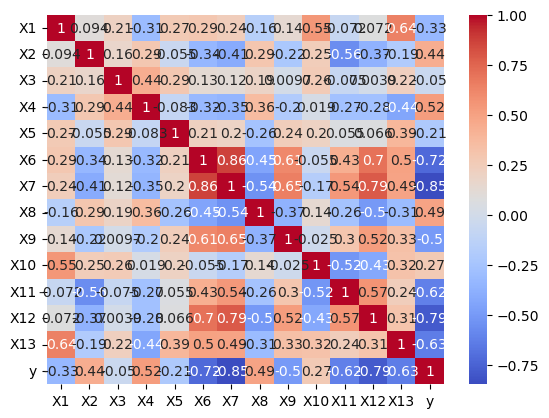

In [282]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = wine_df.corr()  # Calculate correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  # Plot heatmap
plt.show()


Scatter Plots of data correlation from chatgpt

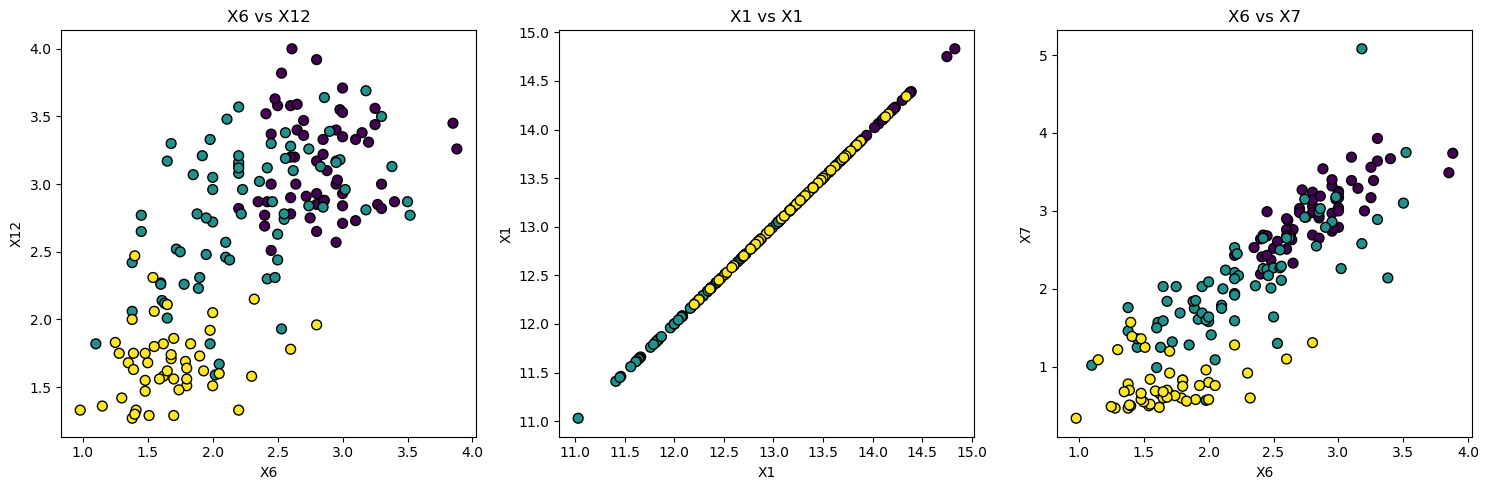

In [283]:


# Assuming 'wine_df' is your DataFrame and 'specific_combinations' is defined
specific_combinations = [
    ('X6', 'X12'),
    ('X1', 'X1'),
    ('X6', 'X7')
]

# Set up the figure for multiple subplots (adjust layout as needed)
n_combinations = len(specific_combinations)

# Create subplots: use (1, n_combinations) for multiple columns or (1, 1) if only one plot
fig, axes = plt.subplots(1, n_combinations, figsize=(15, 5)) if n_combinations > 1 else plt.subplots(1, 1, figsize=(10, 5))

# Convert single axes to a list for consistency
if n_combinations == 1:
    axes = [axes]

# Loop through the feature pairs and create scatter plots
for i, (feature1, feature2) in enumerate(specific_combinations):
    ax = axes[i]  # Select the subplot
    ax.scatter(wine_df[feature1], wine_df[feature2], c=wine_df['y'], cmap='viridis', edgecolor='k', s=50)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title(f'{feature1} vs {feature2}')

# Adjust layout
plt.tight_layout()
plt.show()


Preprocessing of data - scale the data using standard scalers to put into the same scale

In [284]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Set up devices try to run on GPU to accelerate

In [285]:
#device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'

Convert data to tensors

In [286]:
x_train_tensor = torch.tensor(X_train,dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test,dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train,dtype=torch.int64).to(device)
y_test_tensor = torch.tensor(y_test,dtype=torch.int64).to(device)

Create Class for Model

In [287]:
class SimpleClassifierModel(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64,10)
        self.layer4 = nn.Linear(10, out_features)

    #pass data through each layer
    def forward(self,x):
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        return x

        
        

In [288]:
in_features = X_train.shape[1]
out_features = len(set(y))
num_classes = out_features

print(f'in features: {in_features}, out features: {out_features}')

model = SimpleClassifierModel(in_features,num_classes).to(device)

in features: 13, out features: 3


Set up criteria and optimiser

In [289]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.1)

Set training Loop

In [290]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()

    #run forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs,y_train_tensor) #compute loss comparing model predictions and the actual labels

    # Determine the predicted class labels by taking the index of the maximum value in each prediction
    # torch.max returns both the max value and its index; we only care about the index (predicted label)
    _, predicted_labels = torch.max(outputs,1)

    
    # Calculate the number of correct predictions by comparing predicted labels with actual labels
    correct_predictions = (predicted_labels == y_train_tensor).sum().item()


    # Calculate total number of samples and accuracy as the ratio of correct predictions to total samples
    total_samples = len(y_train_tensor)
    acc = correct_predictions / total_samples

    #do backward pass
    optimiser.zero_grad() #clears all gradients to start the next gradient decent on next epoch
    loss.backward() #performs backwards pass
    optimiser.step() # Update the model parameters using the computed gradients (based on the optimization algorithm, e.g., SGD)

    #print the loss and accuracy every 10 epochs

    if(epoch + 1)%10 ==0:
        print(f'epoch [{epoch+1}/{num_epochs}], loss : {loss.item(): .4f}, accuracy: {acc: .4f}')

Evaluate using test data

In [291]:
model.eval()
with torch.inference_mode():
    # Pass the test data through the model to get output predictions (logits)
    outputs = model(X_test_tensor)

    # Find the predicted class labels by taking the index of the maximum value along dimension 1

    _, predicted = torch.max(outputs,1)

    accuracy = accuracy_score(y_test,predicted.numpy())

     # Create a copy of the predicted tensor, detached from the computation graph
    # This ensures the tensor is independent and doesn't track gradients

    predicted_tensor = predicted.clone().detach()

    loss = criterion(outputs,predicted_tensor)

    print(f'loss: {loss.item(): .4f}, accuracy: {accuracy: .4f}')

loss:  0.8712, accuracy:  0.4444


Visulise using confusion matrix

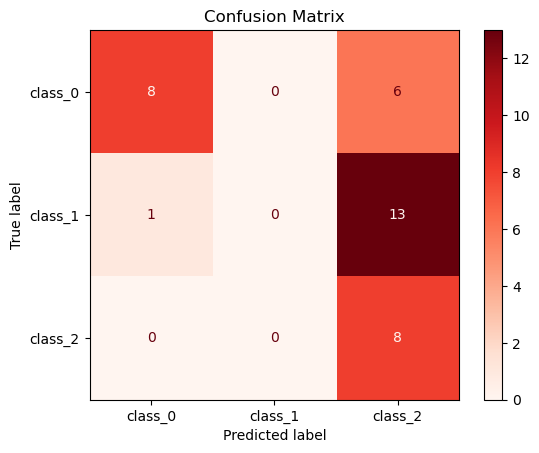

In [292]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate using test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    
    # Convert tensors to numpy arrays
    y_test_np = y_test_tensor.cpu().numpy()
    predicted_np = predicted.cpu().numpy()
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_np, predicted_np, labels=np.arange(num_classes))
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wine.target_names)
    disp.plot(cmap='Reds', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
